In [23]:
import csv
import glob
import os
import h5py
import cv2
import numpy as np
import torch
import trimesh
from PIL import Image
from pathlib import Path
import sys
from argparse import ArgumentParser
from datetime import datetime
import torch
import torch.multiprocessing as mp
import yaml
import numpy as np
from munch import munchify
import wandb


import sys
sys.path.append("D:/gs-localization/gaussian_splatting")
sys.path.append("D:/gs-localization")
from tools.gaussian_model import GaussianModel
from tools.config_utils import load_config, update_recursive
from tools import read_write_model
from tools.eval_utils import rotation_error, translation_error

with open("configs/mono/tum/fr3_office.yaml", "r") as f:
    cfg_special = yaml.full_load(f)

inherit_from = "configs/mono/tum/base_config.yaml"

if inherit_from is not None:
    cfg = load_config(inherit_from)
else:
    cfg = dict()

# merge per dataset cfg. and main cfg.
config = update_recursive(cfg, cfg_special)
config = cfg
    
data_folder = "D:/gs-localization/datasets/7scenes"
config["Dataset"]["Calibration"]["fx"] = 525
config["Dataset"]["Calibration"]["fy"] = 525
config["Dataset"]["Calibration"]["cx"] = 320
config["Dataset"]["Calibration"]["cy"] = 240
config["Dataset"]["Calibration"]["width"] = 640
config["Dataset"]["Calibration"]["height"] = 480

scene = 'redkitchen'
Model = GaussianModel(3, config)
#Model.load_ply("C:/Users/27118/Desktop/master_project/RaDe-GS/output/26b22380-1/point_cloud/iteration_30000/point_cloud.ply")
#Model.load_ply("D:/gaussian-splatting/output/73bdba8c-0/point_cloud/iteration_25000/point_cloud.ply")
Model.load_ply(f"D:/gs-localization/output/7scenes/{scene}/gs_map/iteration_30000/point_cloud.ply")


In [24]:
import cv2
import numpy as np
import torch
from PIL import Image
from pathlib import Path
from tools import read_write_model
from math import atan

def focal2fov(focal, pixels):
    return 2 * atan(pixels / (2 * focal))

def load_pose(pose_txt):
    pose = []
    with open(pose_txt, 'r') as f:
        for line in f:
            row = line.strip('\n').split()
            row = [float(c) for c in row]
            pose.append(row)
    pose = np.array(pose).astype(np.float32)
    assert pose.shape == (4,4)
    return pose

class BaseDataset(torch.utils.data.Dataset):
    def __init__(self, args, path, config):
        self.args = args
        self.path = path
        self.config = config
        self.device = "cuda:0"
        self.dtype = torch.float32
        self.num_imgs = 9999

    def __len__(self):
        return self.num_imgs

    def __getitem__(self, idx):
        pass

class MonocularDataset(BaseDataset):
    def __init__(self, args, path, config):
        super().__init__(args, path, config)
        calibration = config["Dataset"]["Calibration"]
        # Camera prameters
        self.fx = calibration["fx"]
        self.fy = calibration["fy"]
        self.cx = calibration["cx"]
        self.cy = calibration["cy"]
        self.width = calibration["width"]
        self.height = calibration["height"]
        self.fovx = focal2fov(self.fx, self.width)
        self.fovy = focal2fov(self.fy, self.height)
        self.K = np.array(
            [[self.fx, 0.0, self.cx], [0.0, self.fy, self.cy], [0.0, 0.0, 1.0]]
        )
        # distortion parameters
        self.disorted = calibration["distorted"]
        self.dist_coeffs = np.array(
            [
                calibration["k1"],
                calibration["k2"],
                calibration["p1"],
                calibration["p2"],
                calibration["k3"],
            ]
        )
        self.map1x, self.map1y = cv2.initUndistortRectifyMap(
            self.K,
            self.dist_coeffs,
            np.eye(3),
            self.K,
            (self.width, self.height),
            cv2.CV_32FC1,
        )
        # depth parameters
        self.has_depth = True if "depth_scale" in calibration.keys() else False
        self.depth_scale = calibration["depth_scale"] if self.has_depth else None

        # Default scene scale
        nerf_normalization_radius = 5
        self.scene_info = {
            "nerf_normalization": {
                "radius": nerf_normalization_radius,
                "translation": np.zeros(3),
            },
        }

    def __getitem__(self, idx):
        color_path = self.color_paths[idx]
        pose = self.poses[idx]

        image = np.array(Image.open(color_path))
        depth = None

        if self.disorted:
            image = cv2.remap(image, self.map1x, self.map1y, cv2.INTER_LINEAR)

        if self.has_depth:
            depth_path = self.depth_paths[idx]
            depth = np.array(Image.open(depth_path)) / self.depth_scale

        image = (
            torch.from_numpy(image / 255.0)
            .clamp(0.0, 1.0)
            .permute(2, 0, 1)
            .to(device=self.device, dtype=self.dtype)
        )
        pose = torch.from_numpy(pose).to(device=self.device)
        return image, depth, pose


from tqdm import tqdm
class seven_scenes_Dataset(MonocularDataset):
    def __init__(self, args, path, config, data_folder, scene):
        super().__init__(args, path, config)
        self.has_depth = True
        self.seven_scenes_Parser(data_folder, scene) 
        
    def seven_scenes_Parser(self, data_folder, scene):
        self.color_paths, self.poses, self.depth_paths = [], [], []

        gt_dirs = Path(data_folder) / scene / "sparse/0"
        _, images, _ = read_write_model.read_model(gt_dirs, ".txt")
        print("size!!!!!!!!!!!!!!!!!!!", sys.getsizeof(images))

        # Read the filenames from test_fewshot.txt and store them in a set.
        test_images_path = Path(data_folder) / scene / "test_fewshot.txt"
        
        with open(test_images_path, 'r') as f:
            test_images = set(line.strip() for line in f)
            
        for i, image in tqdm(images.items(),"Load dataset"):
            # Execute the following operation only if image.name exists in test_images."
            if image.name in test_images:
                image_path = Path(data_folder) / scene / 'images' / image.name
                depth_path = Path(data_folder) / scene / 'depths' / image.name.replace("color","depth")
                self.color_paths.append(image_path)
                self.depth_paths.append(depth_path)
                R_gt, t_gt = image.qvec2rotmat(), image.tvec
                pose = np.eye(4)            
                pose[:3, :3] = R_gt         
                pose[:3, 3] = t_gt 
                self.poses.append(pose)


        """
        # Sort self.color_paths, self.poses, and self.depth_paths based on normal file name order
        sorted_data = sorted(zip(self.color_paths, self.poses, self.depth_paths), key=lambda x: x[0].name)
        self.color_paths, self.poses, self.depth_paths = zip(*sorted_data)
        """

        # Sort self.color_paths, self.poses, and self.depth_paths based on normal file name order
        sorted_data = sorted(zip(self.color_paths, self.depth_paths, self.poses), key=lambda x: x[0].name)
        self.color_paths, self.depth_paths, self.poses = zip(*sorted_data)

        print("size!!!!!!!!!!!!!!!!!!!", sys.getsizeof(sorted_data))

In [25]:
config["Dataset"]["Calibration"]['depth_scale'] = 1000.0
config["Training"]["alpha"] = 0.99

In [26]:
model_params = munchify(config["model_params"])
pipeline_params = munchify(config["pipeline_params"])
data_folder = "D:/gs-localization/datasets/7scenes"
dataset = seven_scenes_Dataset(model_params, model_params.source_path, config, data_folder, scene)
bg_color = [0, 0, 0] 
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


size!!!!!!!!!!!!!!!!!!! 589920


Load dataset: 100%|███████████████████████████████████████████████████████████| 12000/12000 [00:00<00:00, 33342.00it/s]


size!!!!!!!!!!!!!!!!!!! 41880


In [73]:
from tools.graphics_utils import getProjectionMatrix2, getWorld2View2
from tools import render
from tools.descent_utils import image_gradient, image_gradient_mask
from tools.camera_utils import Camera
from tools.descent_utils import get_loss_tracking
from tools.pose_utils import update_pose

projection_matrix = getProjectionMatrix2(
    znear=0.01,
    zfar=100.0,
    fx=dataset.fx,
    fy=dataset.fy,
    cx=dataset.cx,
    cy=dataset.cy,
    W=dataset.width,
    H=dataset.height,
).transpose(0, 1)
projection_matrix = projection_matrix.to(device="cuda:0")

config["Training"]["opacity_threshold"] = 0.99
config["Training"]["edge_threshold"] = 1.1
from time import time

def gradient_decent(viewpoint, config, initial_R, initial_T):

    viewpoint.update_RT(initial_R, initial_T)
    
    opt_params = []
    opt_params.append(
        {
            "params": [viewpoint.cam_rot_delta],
            "lr": 0.001,
            "name": "rot_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.cam_trans_delta],
            "lr": 0.001,
            "name": "trans_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.exposure_a],
            "lr": 0.001,
            "name": "exposure_a_{}".format(viewpoint.uid),
        }
    )
    opt_params.append(
        {
            "params": [viewpoint.exposure_b],
            "lr": 0.001,
            "name": "exposure_b_{}".format(viewpoint.uid),
        }
    )
    
    pose_optimizer = torch.optim.SGD(opt_params)
    
    for tracking_itr in range(50):
        
        render_pkg = render(
            viewpoint, Model, pipeline_params, background
        )
        
        image, depth, opacity = (
            render_pkg["render"],
            render_pkg["depth"],
            render_pkg["opacity"],
        )
          
        pose_optimizer.zero_grad()
        
        loss_tracking = get_loss_tracking(
            config, image, depth, opacity, viewpoint
        )
        loss_tracking.backward()
        
        with torch.no_grad():
            pose_optimizer.step()
            converged = update_pose(viewpoint, converged_threshold=1e-4)
    
        if converged:
            break
             
    return viewpoint.R, viewpoint.T, render_pkg

from collections import OrderedDict

class Transformation:
    def __init__(self, R=None, T=None):
        self.R = R
        self.T = T

# 使用 OrderedDict 来代替 defaultdict
test_infos = OrderedDict()

def quat_to_rotmat(qvec):
    qvec = np.array(qvec, dtype=float)
    w, x, y, z = qvec
    R = np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x**2 - 2*y**2]
    ])
    return R



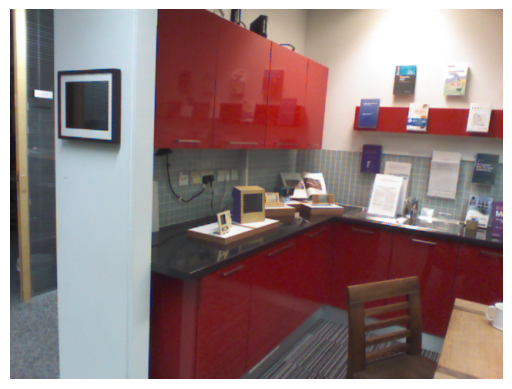

In [74]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# 假设你的tensor图片是dataset[0][0]
image_tensor = dataset[0][0]

# 如果需要，你可以转换tensor的通道顺序（通常是从[Channels, Height, Width]到[Height, Width, Channels]）
# 例如，对于RGB图像，使用permute方法：
image_tensor = image_tensor.permute(1, 2, 0)

# 将tensor移动到CPU上，然后转换为numpy数组
image_np = image_tensor.cpu().numpy()

# 如果你的tensor的值在[0, 1]范围内，则可以直接显示。如果在其他范围，可能需要标准化：
# image_np = (image_np * 255).astype(np.uint8)  # 仅在需要时使用

# 显示图片
plt.imshow(image_np)
plt.axis('off')  # 不显示坐标轴
plt.show()



In [75]:
"""
config["Training"]["monocular"] = True
viewpoint = Camera.init_from_dataset(dataset, 5, projection_matrix)
initial_R = viewpoint.R_gt
initial_T = viewpoint.T_gt
print(initial_T)
viewpoint.compute_grad_mask(config)
rotation_matrix, translation_vector, render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)
"""

'\nconfig["Training"]["monocular"] = True\nviewpoint = Camera.init_from_dataset(dataset, 5, projection_matrix)\ninitial_R = viewpoint.R_gt\ninitial_T = viewpoint.T_gt\nprint(initial_T)\nviewpoint.compute_grad_mask(config)\nrotation_matrix, translation_vector, render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)\n'

In [79]:
# 假设文件已打开并读取
with open(f"D:/gs-localization/output/7scenes/{scene}/results_sparse.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        name = parts[0]
        qvec = list(map(float, parts[1:5]))
        tvec = list(map(float, parts[5:8]))

        R = quat_to_rotmat(qvec)
        T = np.array(tvec)

        # 直接在 OrderedDict 中插入数据
        test_infos[name] = Transformation(R=R, T=T)

# 对 OrderedDict 按 name 进行排序
test_infos = OrderedDict(sorted(test_infos.items(), key=lambda item: item[0]))

def create_mask(mkpts_lst, width, height, k):
    # 初始化 mask，全为 False
    mask = np.zeros((height, width), dtype=bool)
    
    # 计算 k 的半径
    half_k = k // 2
    
    # 遍历所有点
    for pt in mkpts_lst:
        x, y = int(pt[0]), int(pt[1])
        
        # 计算 k*k 区域的边界
        x_min = max(0, x - half_k)
        x_max = min(width, x + half_k + 1)
        y_min = max(0, y - half_k)
        y_max = min(height, y + half_k + 1)
        
        # 设置 mask 中的 k*k 区域为 True
        mask[y_min:y_max, x_min:x_max] = True
    
    # 形状为 (1, height, width)
    mask = mask[np.newaxis, :, :]
    
    return mask

rot_errors = []
trans_errors = []

file = h5py.File(f'D:/gs-localization/output/7scenes/{scene}/feats-superpoint-n4096-r1024.h5', 'r')

from tqdm import tqdm
for i, image in enumerate(tqdm(test_infos, desc="Localization:")):
    viewpoint = Camera.init_from_dataset(dataset, i, projection_matrix)

    viewpoint.compute_grad_mask(config)
    
    group = file[image] 
    keypoints = group['keypoints'][group['scores'][:]>0.2]  
    mask = create_mask(mkpts_lst=keypoints, width=dataset.width, height=dataset.height, k=10)
    viewpoint.grad_mask = viewpoint.grad_mask | torch.tensor(mask).to("cuda:0")

    config["Training"]["monocular"] = True

    initial_R = torch.tensor(test_infos[image].R)
    initial_T = torch.tensor(test_infos[image].T).squeeze()

    rotation_matrix, translation_vector, render_pkg = gradient_decent(viewpoint, config, initial_R, initial_T)
    #rotation_matrix, translation_vector = initial_R, initial_T

    R_gt = viewpoint.R_gt.cpu().numpy()
    t_gt = viewpoint.T_gt.reshape(3,1).cpu().numpy()
    R = rotation_matrix.cpu().numpy()
    t = translation_vector.reshape(3,1).cpu().numpy()
    trans_error = np.linalg.norm(-R_gt.T @ t_gt + R.T @ t, axis=0)
    cos = np.clip((np.trace(np.dot(R_gt.T, R)) - 1) / 2, -1.0, 1.0)
    rot_error = np.rad2deg(np.abs(np.arccos(cos)))
    
    #rot_error = rotation_error(rotation_matrix.cpu().numpy(), viewpoint.R_gt.cpu().numpy())
    #trans_error = translation_error(translation_vector.reshape(3,1).cpu().numpy(), viewpoint.T_gt.reshape(3,1).cpu().numpy())
    rot_errors.append(rot_error)
    trans_errors.append(trans_error)

file.close()

"""
SCENES = ['bicycle', 'bonsai', 'counter', 'garden',  'kitchen', 'room', 'stump']


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--scenes", default=SCENES, choices=SCENES, nargs="+")
    parser.add_argument("--overwrite", action="store_true")
    parser.add_argument(
        "--dataset",
        type=Path,
        default="datasets/360_v2",
        help="Path to the dataset, default: %(default)s",
    )
    parser.add_argument(
        "--outputs",
        type=Path,
        default="output/360_v2",
        help="Path to the output directory, default: %(default)s",
    )

    parser.add_argument(
        "--num_covis",
        type=int,
        default=30,
        help="Number of image pairs for SfM, default: %(default)s",
    )

    parser.add_argument(
        "--num_retrieve",
        type=int,
        default=3,
        help="Number of images for retrieval, default: %(default)s",
    )
    args = parser.parse_args()

    gt_dirs = args.dataset / "{scene}/sparse/0" 
    tr_dirs = args.dataset / "{scene}/train_views/triangulated" 

    for scene in args.scenes:
        logger.info(f'Working on scene "{scene}".')
        if args.overwrite or True:
            run_scene(
                args.dataset / scene / "images_4",
                Path(str(gt_dirs).format(scene=scene)),
                Path(str(tr_dirs).format(scene=scene)), 
                args.dataset / scene,
                args.outputs / scene,
                args.num_covis,
                args.num_retrieve)

"""

Localization:: 100%|███████████████████████████████████████████████████████████████| 5000/5000 [39:11<00:00,  2.13it/s]


'\nSCENES = [\'bicycle\', \'bonsai\', \'counter\', \'garden\',  \'kitchen\', \'room\', \'stump\']\n\n\nif __name__ == "__main__":\n    parser = argparse.ArgumentParser()\n    parser.add_argument("--scenes", default=SCENES, choices=SCENES, nargs="+")\n    parser.add_argument("--overwrite", action="store_true")\n    parser.add_argument(\n        "--dataset",\n        type=Path,\n        default="datasets/360_v2",\n        help="Path to the dataset, default: %(default)s",\n    )\n    parser.add_argument(\n        "--outputs",\n        type=Path,\n        default="output/360_v2",\n        help="Path to the output directory, default: %(default)s",\n    )\n\n    parser.add_argument(\n        "--num_covis",\n        type=int,\n        default=30,\n        help="Number of image pairs for SfM, default: %(default)s",\n    )\n\n    parser.add_argument(\n        "--num_retrieve",\n        type=int,\n        default=3,\n        help="Number of images for retrieval, default: %(default)s",\n    )\n  

In [80]:
med_t = np.median(trans_errors)
med_R = np.median(rot_errors)
print( f"\nMedian errors: {med_t:.3f}m, {med_R:.3f}deg")

threshs_t = [0.01, 0.02, 0.03, 0.05, 0.25, 0.5, 5.0]
threshs_R = [1.0, 2.0, 3.0, 5.0, 2.0, 5.0, 10.0]
for th_t, th_R in zip(threshs_t, threshs_R):
    ratio = np.mean((np.array(trans_errors) < th_t) & (np.array(rot_errors) < th_R))
    print(f"\n\t{th_t*100:.0f}cm, {th_R:.0f}deg : {ratio*100:.2f}%")


Median errors: 0.007m, 0.183deg

	1cm, 1deg : 69.14%

	2cm, 2deg : 94.46%

	3cm, 3deg : 98.30%

	5cm, 5deg : 98.92%

	25cm, 2deg : 99.42%

	50cm, 5deg : 99.50%

	500cm, 10deg : 99.84%


In [15]:
def qvec2rotmat(qvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ]
    )


def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = (
        np.array(
            [
                [Rxx - Ryy - Rzz, 0, 0, 0],
                [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
                [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
                [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz],
            ]
        )
        / 3.0
    )
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec

from tools.read_write_model import read_images_text
def evaluate(model, results, list_file=None, only_localized=False):
    predictions = {}
    with open(results, "r") as f:
        for data in f.read().rstrip().split("\n"):
            data = data.split()
            name = data[0]
            q, t = np.split(np.array(data[1:], float), [4])
            predictions[name] = (qvec2rotmat(q), t)

    images = read_images_text(Path(model) / "images.txt")
    name2id = {image.name: i for i, image in images.items()}

    if list_file is None:
        test_names = list(name2id)
    else:
        with open(list_file, "r") as f:
            test_names = f.read().rstrip().split("\n")

    errors_t = []
    errors_R = []
    for name in test_names:
        if name not in predictions:
            if only_localized:
                continue
            e_t = np.inf
            e_R = 180.0
        else:
            image = images[name2id[name]]
            R_gt, t_gt = image.qvec2rotmat(), image.tvec
            R, t = predictions[name]
            e_t = np.linalg.norm(-R_gt.T @ t_gt + R.T @ t, axis=0)
            cos = np.clip((np.trace(np.dot(R_gt.T, R)) - 1) / 2, -1.0, 1.0)
            e_R = np.rad2deg(np.abs(np.arccos(cos)))
        errors_t.append(e_t)
        errors_R.append(e_R)

    errors_t = np.array(errors_t)
    errors_R = np.array(errors_R)

    med_t = np.median(errors_t)
    med_R = np.median(errors_R)
    out = ""
    out += f"\nMedian errors: {med_t:.3f}m, {med_R:.3f}deg"

    out += "\nPercentage of test images localized within:"
    threshs_t = [0.01, 0.02, 0.03, 0.05, 0.25, 0.5, 5.0]
    threshs_R = [1.0, 2.0, 3.0, 5.0, 2.0, 5.0, 10.0]
    for th_t, th_R in zip(threshs_t, threshs_R):
        ratio = np.mean((errors_t < th_t) & (errors_R < th_R))
        out += f"\n\t{th_t*100:.0f}cm, {th_R:.0f}deg : {ratio*100:.2f}%"

    print(out)


evaluate("D:/gs-localization/datasets/7scenes/heads/sparse/0", 
         "D:/gs-localization/output/7scenes/heads/results_sparse.txt", 
         "D:/gs-localization/datasets/7scenes/heads/test_fewshot.txt")


Median errors: 0.007m, 0.496deg
Percentage of test images localized within:
	1cm, 1deg : 64.80%
	2cm, 2deg : 91.70%
	3cm, 3deg : 95.50%
	5cm, 5deg : 97.50%
	25cm, 2deg : 96.90%
	50cm, 5deg : 98.70%
	500cm, 10deg : 98.90%


In [16]:
import h5py

# 打开 HDF5 文件
with h5py.File('D:/gs-localization/output/360_v2/stump/feats-superpoint-n4096-r1024.h5', 'r') as file:
    # 指定要读取的图像 key
    target_image_key = '_DSC9266.JPG'
    
    # 获取该图像对应的组
    group = file[target_image_key]
    
    # 提取 keypoints 数据集并存储为 mkpts_lst
    mkpts_lst = group['keypoints'][:]
    
    # 打印结果确认
    print(f"Shape of mkpts_lst: {mkpts_lst.shape}")
    print(f"Keypoints (first few): \n{mkpts_lst[:10]}")


Shape of mkpts_lst: (2205, 2)
Keypoints (first few): 
[[  74.25    9.83]
 [ 108.3     9.83]
 [ 452.5     9.83]
 [ 541.      9.83]
 [ 587.5     9.83]
 [ 631.      9.83]
 [ 648.      9.83]
 [ 694.5     9.83]
 [1042.      9.83]
 [1192.      9.83]]


In [17]:
import h5py

# 打开 HDF5 文件
with h5py.File('D:/gs-localization/output/360_v2/bicycle/feats-superpoint-n4096-r1024.h5', 'r') as file:
    # 查看文件中的所有顶层组（类似于文件夹）
    keys = list(file.keys())
    print("Keys: ", keys)
    
    # 假设你想读取'_DSC8679.JPG'组中的数据
    first_image_key = keys[0]  # '_DSC8679.JPG'
    group = file[first_image_key]  # 获取组对象
    
    # 读取'descriptors'数据集
    descriptors = group['descriptors'][:]
    print(f"Shape of descriptors: {descriptors.shape}")
    print(f"Descriptors (first few): \n{descriptors[:10]}")
    
    # 读取'image_size'数据集
    image_size = group['image_size'][:]
    print(f"Image size: {image_size}")
    
    # 读取'keypoints'数据集
    keypoints = group['keypoints'][:]
    print(f"Shape of keypoints: {keypoints.shape}")
    print(f"Keypoints (first few): \n{keypoints[:10]}")
    print(keypoints[:][])
    
    # 读取'scores'数据集
    scores = group['scores'][:]
    print(f"Shape of scores: {scores.shape}")
    print(f"Scores (first few): \n{scores[:10]}")


SyntaxError: invalid syntax (2539920790.py, line 26)

In [ ]:
#read_write_model.read_cameras_binary("D:/gs-localization/datasets/nerf_llff_data/fern/train_views/triangulated/cameras.bin")